In [1]:
pip install python-mnist==0.5 # 다운받은 data 불러오는 라이브러리

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-mnist: filename=python_mnist-0.5-py3-none-any.whl size=11114 sha256=8e04ac64b99c82f7f10ef9766c80de2fb545c851c4387bd2cb8f326583e3b625
  Stored in directory: /root/.cache/pip/wheels/67/d1/46/43124d12260cf439a101157c358c8c2df565fd1744fa81a742
Successfully built python-mnist


- 유명한 손글씨 데이터인 MNIST를 이용해서, 다양한 방식으로 딥러닝 모델 학습

  - Optimization 방법을 이용하여 training 속도를 높여줌
  - 기존에 배운 Ridge model이 아닌 새롭게 배우는 overfitting 방지법인 Dropout의 개념을 이해하고 코드로 구현
  - Training 하는 동안, layer들을 하나하나 정규화 시켜주는 batch normalization을 실습

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import random

from mnist import MNIST

import torch.utils.data as data_utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

- Check GPU and fix the random seed

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)

if device=='cuda':
  torch.cuda.manual_seed_all(777)

cpu


# Import Dataset

In [4]:
mnist = MNIST('/content/drive/MyDrive/Colab Notebooks/data/raw')

In [5]:
x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

In [6]:
print(len(x_test))
x_test[:3]

10000


[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


- 숫자가 낮을수록 어두운 색깔
- 숫자가 높을수록 밝은 색깔

# Data Preprocessing

- data는 list 형식으로 되어 있으므로 shape를 보고, 이미지 visualization을 하기 편한 array 형태로 바꿔주어야 함

In [7]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [8]:
print("x_train의 shape = {}, y_train의 shape = {}".format(x_train.shape, y_train.shape))
print("x_test의 shape = {}, y_test의 shape = {}".format(x_test.shape, y_test.shape))

x_train의 shape = (60000, 784), y_train의 shape = (60000,)
x_test의 shape = (10000, 784), y_test의 shape = (10000,)


- train set은 6만개의 데이터 + 784 차원
- 784 = 28*28
- mnist는 28*28 이미지

# Data Visualization

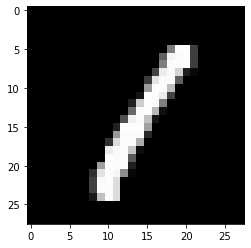

그때의 숫자 1


In [9]:
plt.imshow((np.array(x_train[3]).reshape(28,28)),cmap='gray')
plt.show()
print("그때의 숫자", y_train[3])

# MNIST dataset을 dataloader를 이용해서 실제 변수에 담기

- Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 함
- 모델을 학습할 때, 일반적으로 샘플들은 "미니배치(minibatch)"로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, python의 multiprocessing을 사용하여 데이터 검색 속도를 높이려고 함

- DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)

In [10]:
batch_size = 1000
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
trainloader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)

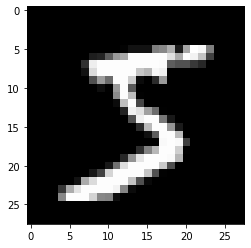

tensor(5.)


In [11]:
for x,y in train_data:
  plt.imshow(x.reshape(28,28), cmap='gray')
  plt.show()

  print(y)
  
  break

## DataLoader 함수

- dataloader에는 배치사이즈만큼 묶여서 x_data와 y_data가 pair로 묶여있음

In [12]:
length = len(trainloader)
print("{}개의 image가 batch size {}로 묶여서 총 {}개의 batch 묶음이 생겼다.".format(len(x_train), batch_size, length))

60000개의 image가 batch size 1000로 묶여서 총 60개의 batch 묶음이 생겼다.


tensor(0.)


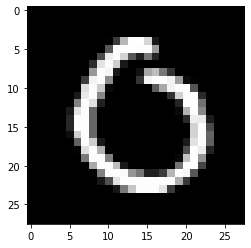

In [13]:
for batch_idx, (x_data, y_data) in enumerate(trainloader):
  plt.imshow(x_data[0].numpy().reshape(28,28), cmap='gray')
  print(y_data[0])
  break

# Build Model USING Sequential Method

In [14]:
# 뉴럴 layer 생성
linear1 = torch.nn.Linear(784,256)
linear2 = torch.nn.Linear(256,64)
linear3 = torch.nn.Linear(64,10) # y class가 0~9로 10개
relu = torch.nn.ReLU()

In [15]:
# Sequentail을 이용해 model 설정
# 위의 뉴럴 layer들을 가지고 오기

model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3)
model = model.to(device) #cpu 메모리에 올라감
model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)

## Set Parameters

In [16]:
epoch = 15
learning_rate = 0.01
weight_decay = 1e-5

Cross Entropy 의 중요한 점은<br>
"The losses are averaged across observations for each minibatch."<br>
즉 미니배치들의 ` 평균 값` 을 구해준다는 것이다. <br><br>
ex) mini batch size 가 32면 32개 image data 의 loss 값의 평균을 구해준다<br>
이는 나중에 epoch 마다 loss 값을 구할 때 꼭 고려되어야 하는 부분이다.<br>
(= 모든 이미지 갯수만큼이 아닌, ` mini batch 의 갯수` 만큼 나누어준다)

In [17]:
# CrossEntropyLoss 내에 Softmax function이 포함되어 있으므로 따로 설정해 줄 필요가 없음
loss_function = torch.nn.CrossEntropyLoss()

# 먼저 optimizer는 SGD로 설정
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Model train(SGD)

1. Optimizer는 SGD 방법을 사용 <br>
2. x input을 받는 model은 y_predict 변수에 넣어준다 <br>
3. 정의한 loss function을 이용해서 loss를 구한 후 <br>
4. back propagation으로 gradient를 구해간다 <br>
5. optimizer_SGD.step()으로 weight를 update한다. <br>

1. for 문에 epoch를 담아주고 <br>
2. 그 안에 또 다시 for문을 하나 더 담아서 mini batch를 하나씩 돌린다.
3. mini batch마다 image와 label을 하나씩 불러와서 to(device)를 써서 gpu 또는 cpu 메모리 위에 올려놓은 후
4. optimizer.zero_grad로 weight를 초기화 한 후
5. model에 image를 넣어서 prediction 값을 뽑아낸 후
6. 미리 정의해둔 loss function으로 loss 갑을 얻어낸다.
7. loss.backward()를 사용하여
8. optimizer.step()을 이용해 weight 값을 update 한 후 for문이 다 돌 떄까지 기다림


In [18]:
# Model Train(SGD)

loss_list = []

for epoch_num in range(epoch):
    average_cost = 0
      
    for batch_idx, (x_data, y_label) in enumerate(trainloader):
        num_of_mini_batch = len(trainloader) # 60
        # trainloader loader 의 length는 아까 보았듯이 총 60개 (batch_size = 1000 이고 총 data 는 60000개 이므로)
        # epoch 하나당 평균 loss 를 구해주어야 할 때 꼭 필요하다
            
        # train 시킬 image data
        input_image = x_data.to(device)
        label = y_label.to(device)
                
        # Gradient 초기화
        optimizer.zero_grad()
        
        # Model 에 train data 를 넣고 predict 값 산출
        y_predict = model(input_image)
        
        # Loss fucntion 에 넣어서 계산하기 위해 y data의 type 을 바꿔준다
        y_label_long = torch.tensor(label, dtype=torch.long)
        y_label_long = y_label_long.to(device)
        
        # Softmax 와 Cross Entropy 를 한 꺼번에 구현
        # 배치 한 묶음안에 있는 image 의 평균 loss 값이 저장
        loss = loss_function(y_predict, y_label_long)
        if batch_idx % 10 == 0:
            print("loss value %.5f" %(loss.item()))
        
        # Back Propagation
        loss.backward()
        
        # Optimizer 를 한 step 내딛는다 -> w 의 값을 갱신
        optimizer.step()
             
        # epoch 마다 평균 loss 를 구하기 위해 average loss 값을 update
        # loss.item() 명령어를 내려서 연산이 가능하게끔 바꾸어준다
        # print(type(loss)) => 'torch.Tensor'
        # print(type(loss.item())) => 'float'
        average_cost = average_cost + (loss.item()/num_of_mini_batch) # +=
        
        # 각 batch 한 묶음에 관한 loss 값 저장 (후에 plot 을 그릴 예정)
        # loss 는 mini batch 하나의 평균 loss 가 들어가있다
        loss_list.append(loss.item())
        
    # epoch 마다 평균 loss 값을 print
    print("epoch {} 의 평균 loss 값은 ==> {:.5f}".format((epoch_num+1), average_cost))

loss value 12.58143
loss value 3.17859
loss value 1.58899
loss value 1.46879
loss value 0.98956
loss value 1.12188
epoch 1 의 평균 loss 값은 ==> 13.37584
loss value 1.54245
loss value 0.84046
loss value 0.69211
loss value 0.71221
loss value 0.69636
loss value 0.45155
epoch 2 의 평균 loss 값은 ==> 0.70472
loss value 0.48291
loss value 0.33103
loss value 0.37789
loss value 0.33167
loss value 0.37504
loss value 0.35650
epoch 3 의 평균 loss 값은 ==> 0.39254
loss value 0.34139
loss value 0.29327
loss value 0.26492
loss value 0.33873
loss value 0.33421
loss value 0.30235
epoch 4 의 평균 loss 값은 ==> 0.29926
loss value 0.22141
loss value 0.24367
loss value 0.30449
loss value 0.31598
loss value 0.28319
loss value 0.24269
epoch 5 의 평균 loss 값은 ==> 0.26590
loss value 0.24456
loss value 0.23561
loss value 0.27340
loss value 0.29779
loss value 0.24260
loss value 0.25468
epoch 6 의 평균 loss 값은 ==> 0.24308
loss value 0.22787
loss value 0.28168
loss value 0.18345
loss value 0.24748
loss value 0.22432
loss value 0.25331
ep

## Epoch 1 (첫번째 epoch)의 loss 값을 계산

In [19]:
# epoch 하나당 60개의 batch 묶음
epoch_loss = 0
for i in range(60):
  epoch_loss = epoch_loss + loss_list[i]

print(epoch_loss/60)

13.375844289859137


## Check Loss value and plotting

- 60,000개를 1,000 배치로 나누었을 때 60이 되므로 epoch 하나당 60 묶음의 배치 학습
- 15 epoch이므로 900 묶음의 배치가 학습이 되게 되고 list에 append 되는 loss value도 900개가 된다

In [20]:
print("loss_list의 길이: ", len(loss_list))

loss_list의 길이:  900


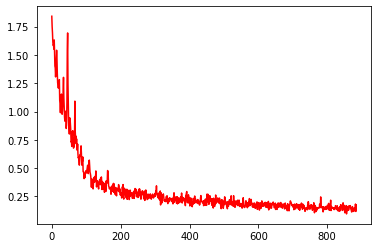

In [21]:
# 처음부터 그리면 초반 5개 정도는 loss 값이 급격하게 낮아지므로 변화량을 제대로 확인하기가 어렵다.
plt.plot(np.array(loss_list[15:]), 'r')

## Loss List의 값을 저장

In [22]:
# plot 비교를 위해 pickle 형태로 저장
import pickle

with open('SGD.pickle', 'wb') as f:
  pickle.dump(loss_list, f)

# Test and Check the accuracy

In [23]:
test_data = data_utils.TensorDataset(torch.FloatTensor(x_test),
                                     torch.FloatTensor(y_test))

testloader = data_utils.DataLoader(test_data, batch_size=5000, shuffle=False)

In [24]:
# test data는 gradient를 계산할 필요가 없다
with torch.no_grad():
  num_total_data = 0
  correct = 0 # 맞는 것의 갯수를 count
  
  for batch_idx, (images, labels) in enumerate(testloader):

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    outputs_softmax = torch.nn.functional.softmax(outputs)

    # softmax를 이용해 probability가 가장 큰 index를 가져옴
    predicted = torch.argmax(outputs_softmax, dim=1)

    # len(images)는 결국 배치 size를 나타내는 것이므로 batch size를 계속 더해주면 data의 총 길이가 된다
    num_total_data = num_total_data + len(images)

    # 맞게 예측한 것만 세어야하는데 이때 쓸 수 있는 좋은 방법(True is equal to 1)를 이용하는 것
    # item()을 해주면 tensor type을 벗어던지고 단순한 float 형식으로 다시 태어날 수 있음

    answer = sum(labels==predicted).item()
    correct = correct + answer

  print("SGD를 이용한 모델의 정확도는 {:.5f}%".format((correct/num_total_data)*100))

SGD를 이용한 모델의 정확도는 95.17000%


In [25]:
len(images)

5000

In [26]:
num_total_data

10000

## Check the accuracy using Original Image & Predicted Label

예측한 숫자는 3이다.


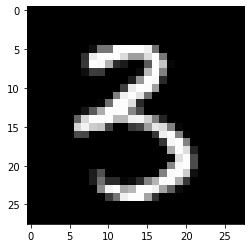

In [27]:
print("예측한 숫자는 {}이다.".format(predicted[0]))
plt.imshow(images[0].cpu().reshape(28,28), cmap='gray')